# The signature of Greenbelts

In [78]:
import geopandas, pandas
from pyogrio import read_dataframe

## Data

### Greenbelts

Download if not available:

In [91]:
gb_url = (
    'https://maps.communities.gov.uk/geoserver/dclg_inspire/ows'
    '?service=WFS&version=2.0.0&request=GetFeature&'
    'typeName=dclg_inspire:England_Green_Belt_2017-18_WGS84&'
    'outputFormat=json&srsName=EPSG:27700'
)

Read up:

In [94]:
%%time
gb = read_dataframe(
    gb_url,
    #where="GB_Name='Merseyside and Greater Manchester'"
)

CPU times: user 4.46 s, sys: 491 ms, total: 4.95 s
Wall time: 16.3 s


### Signatures

- Pull data if not present

In [19]:
try:
    open('signatures.gpkg').close()
except:
    ! wget https://figshare.com/ndownloader/files/30904861 -O signatures.gpkg

- Read and clip

In [70]:
def read_clip(geom, p='signatures.gpkg'):
    return geopandas.read_file(
        p, mask=geom
    ).clip(geom)

import dask.bag as db
from dask.diagnostics import ProgressBar

bag = db.from_sequence(gb.geometry.tolist()).map(read_clip)
with ProgressBar():
    clipped = pandas.concat(bag.compute())

[                                        ] | 0% Completed |  3.0s

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


[########################################] | 100% Completed |  3min 21.3s


## Analysis

### Newcastle

In [72]:
areas = (
    clipped
    .assign(area=clipped.area/1e6)
    .groupby('type')
    ['area']
    .sum()
    .sort_values(ascending=False)
)
pandas.DataFrame({'area_SqKm': areas, 'pct': areas * 100 / areas.sum()})

,area_SqKm,pct
type,,
Urban buffer,1159.736637,46.634218
Countryside agriculture,949.702936,38.188544
Open sprawl,276.501964,11.118432
Warehouse/Park land,64.006638,2.573774
Accessible suburbia,26.218758,1.054284
Wild countryside,4.106897,0.165143
Connected residential neighbourhoods,2.882481,0.115908
Dense residential neighbourhoods,2.162715,0.086965
Disconnected suburbia,1.517039,0.061002


In [ ]:
clipped.dissolve('type').reset_index().explore(
    column='type', categorical=True, tiles='CartoDB dark_matter'
)

## England

In [74]:
clipped_all = geopandas.read_parquet('ss_clipped.pq')
areas = (
    clipped_all
    .assign(area=clipped_all.area/1e6)
    .groupby('type')
    ['area']
    .sum()
    .sort_values(ascending=False)
)
pandas.DataFrame({'area_SqKm': areas, 'pct': areas * 100 / areas.sum()})

,area_SqKm,pct
type,,
Urban buffer,7616.285193,47.000857
Countryside agriculture,7070.798905,43.634607
Open sprawl,828.546604,5.113044
Warehouse/Park land,441.630946,2.725349
Wild countryside,122.253761,0.754440
Accessible suburbia,90.120589,0.556143
Dense residential neighbourhoods,14.027865,0.086567
Disconnected suburbia,7.759982,0.047888
Dense urban neighbourhoods,6.503345,0.040133


In [25]:
%%time
diss = clipped.dissolve('type')

CPU times: user 1min 3s, sys: 262 ms, total: 1min 4s
Wall time: 1min 4s


In [27]:
diss

,geometry,id,code
type,,,
Accessible suburbia,"MULTIPOLYGON (((345756.808 364158.178, 345757....",16693_ACS,ACS
Connected residential neighbourhoods,"MULTIPOLYGON (((357445.040 170360.777, 357455....",87517_CRN,CRN
Countryside agriculture,"MULTIPOLYGON (((344905.850 166541.448, 344906....",459_COA,COA
Dense residential neighbourhoods,"MULTIPOLYGON (((321066.452 387154.549, 321067....",82049_DRN,DRN
Dense urban neighbourhoods,"MULTIPOLYGON (((451541.205 205161.991, 451539....",93538_DUN,DUN
Disconnected suburbia,"MULTIPOLYGON (((389295.261 287291.254, 389295....",72390_DIS,DIS
Gridded residential quarters,"MULTIPOLYGON (((430895.112 280263.914, 430896....",57941_GRQ,GRQ
Hyper concentrated urbanity,"MULTIPOLYGON (((581550.000 185035.000, 581759....",96691_HDU,HDU
Local urbanity,"MULTIPOLYGON (((451614.396 205420.349, 451503....",95707_LOU,LOU


<AxesSubplot:>

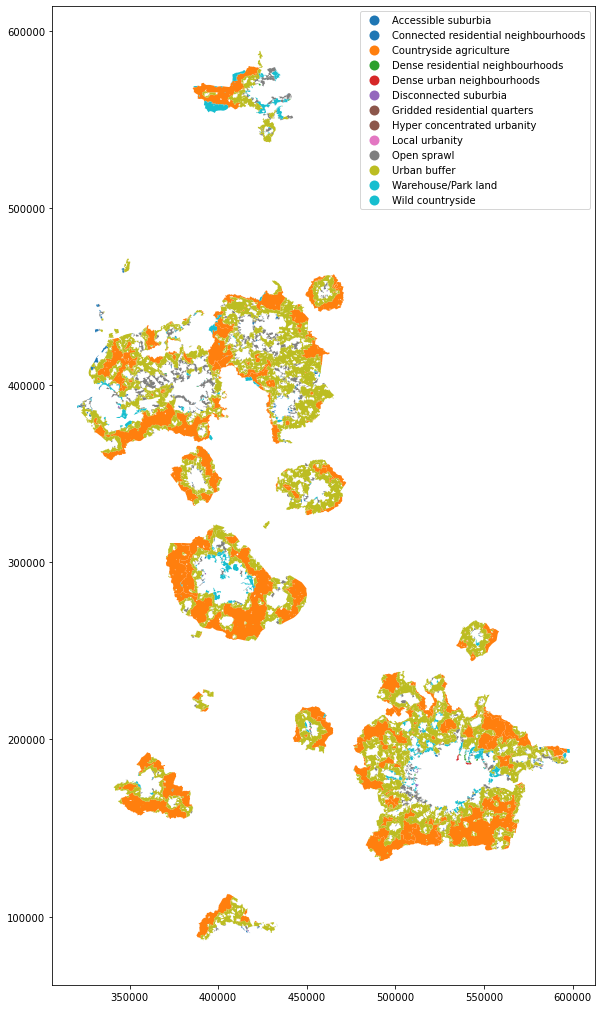

In [31]:
diss.reset_index().plot(
    column='type', categorical=True, legend=True, figsize=(18, 18)
)

- [ ] Clip signatures to green belts
- [ ] Calculate area of green belt by signature